In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

import time
import random
from tqdm.auto import tqdm

!pip install torchmetrics
from torchmetrics import Accuracy

In [ ]:
print(f"Pytorch version : {torch.__version__} | torchvision version {torchvision.__version__}")

Pytorch version : 2.9.0+cu126 | torchvision version 0.24.0+cu126


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Fri Jan 30 16:07:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             30W /   70W |     190MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Setting up data

# Setting up training data
train_data = datasets.CIFAR10(root="data", # Where to download data
                              train=True, # Get training data
                              transform=ToTensor(), # Image comes as a PIL format so we turn it into tensor
                              target_transform=None, # Transform labels
                              download=True,) # Download data if it doesn't exist on disk

# Setting up testing data
test_data = datasets.CIFAR10(root="data", # Where to download data
                             train=False, # Get testing data
                             transform=ToTensor(), # Image comes as a PIL format so we turn it into tensor
                             download=True) # Download data if it doesn't exist on disk

In [ ]:
# A first visualization of the data
image, label = train_data[0]
print(f"Image tensor shape : {image.shape} -> [cc, height, width] | Label : {label}")

Image tensor shape : torch.Size([3, 32, 32]) -> [cc, height, width] | Label : 6


In [ ]:
# Samples number
print(f"Number of sample i the training set : {(len(train_data), len(train_data.targets))}")
print(f"Number of sample i the testing set : {(len(test_data), len(test_data.targets))}")

Number of sample i the training set : (50000, 50000)
Number of sample i the testing set : (10000, 10000)


In [ ]:
# Class names
class_names = train_data.classes
print(f"Class names : {class_names}")

Class names : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Text(0.5, 1.0, 'frog')

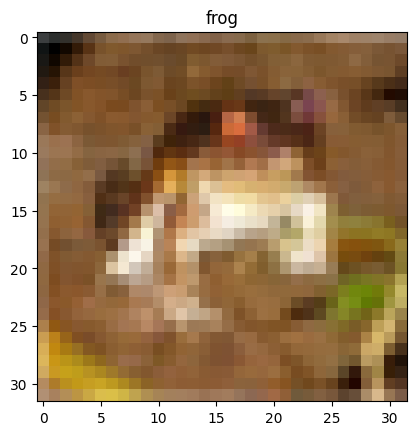

In [ ]:
# Set random seed
torch.manual_seed(42)

# Visualizing data
plt.imshow(image.permute(1, 2, 0)) # permute to respect matplotlib convention
plt.title(f"{class_names[label]}")

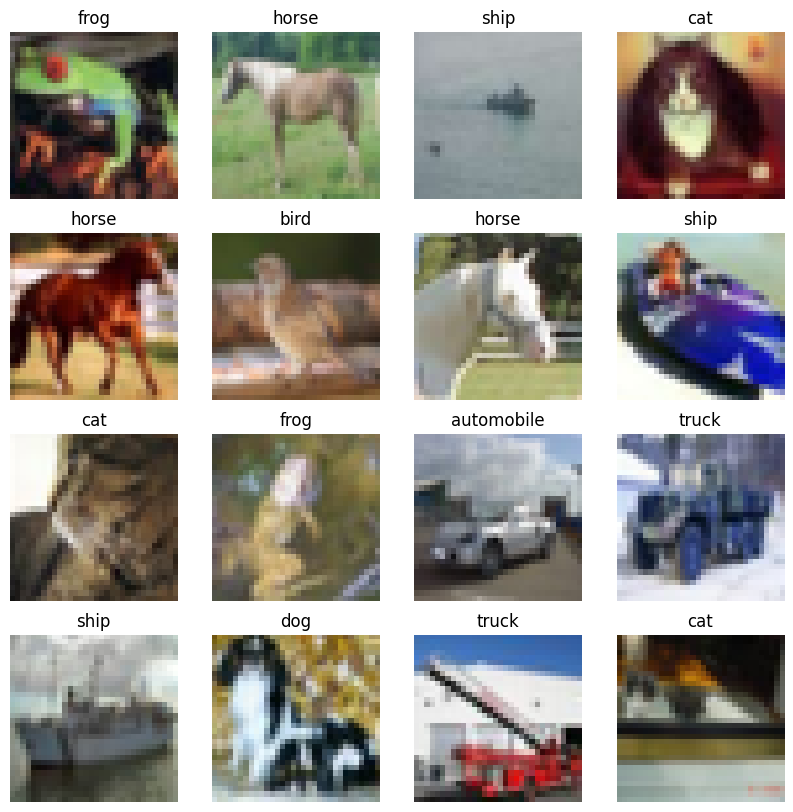

In [ ]:
# Set seed
torch.manual_seed(42)

# More images
fig = plt.figure(figsize=(10,10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
# Hyperparameters
BATCH_SIZE = 32 # How many images per batch
COLOR_CHANNELS = 3 # How many color channels i nthe input image
HIDDEN_UNITS = 10 # How many filter in a convolutional layer
OUTPUT_SHAPE = len(class_names) # How many classes
EPOCHS = 4 # One epoch means every training sample has been seen once by the model

In [ ]:
# Turn train dataset into iterable batches
train_dataloader = DataLoader(dataset=train_data, # What data to turn into
                              batch_size=BATCH_SIZE, # Samples per batch
                              shuffle=True) # Shuffle training data every epoch

# Turn test dataset into iterable batches
test_dataloader = DataLoader(dataset=test_data, # What data to turn into
                             batch_size=BATCH_SIZE, # Samples per batch
                             shuffle=False) # No shuffle for testing data

In [ ]:
print(f"Lenght of training dataloader : {len(train_dataloader)} of {BATCH_SIZE} samples")
print(f"Lenght of testing dataloader : {len(test_dataloader)} of {BATCH_SIZE} samples")

Lenght of training dataloader : 1563 of 32 samples
Lenght of testing dataloader : 313 of 32 samples


In [ ]:
# One batch
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"{train_features_batch.shape}->[batch_size, cc, height, width] | {train_labels_batch.shape}")

torch.Size([32, 3, 32, 32])->[batch_size, cc, height, width] | torch.Size([32])


In [ ]:
# CNN Model
class CNN(nn.Module):
  """
  Model architecture from https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    """
    Initializes the CNN model layers.

    Arguments:
      - input_shape: Number of input color channels.
      - hidden_units: Number of hidden units (filters) per convolutional layer.
      - output_shape: Number of output units/classes.
    """
    super().__init__()

    self.conv_block1 = nn.Sequential(
                nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*8*8,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self. conv_block2(x)
    x = self.classifier(x)
    return x

In [ ]:
# Recall of my image shape
image.shape

torch.Size([3, 32, 32])

In [ ]:
# My model
model = CNN(input_shape=COLOR_CHANNELS,
            hidden_units=HIDDEN_UNITS,
            output_shape=OUTPUT_SHAPE).to(device)

In [ ]:
# Trick to have classifier layer input shape
# Otherwise do caculation with PyTorch doc
random_image_tensor = torch.rand(size=(3, 32, 32))
random_image_tensor.shape
model(random_image_tensor.unsqueeze(0).to(device))

tensor([[-0.0481, -0.0185, -0.0061,  0.0104,  0.0514,  0.0196, -0.0110, -0.0443,
         -0.0071,  0.0130]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# What is to be learned inside my model
for name, param in model.named_parameters():
    print(f"Couche: {name} | Taille: {param.size()}")

Couche: conv_block1.0.weight | Taille: torch.Size([10, 3, 3, 3])
Couche: conv_block1.0.bias | Taille: torch.Size([10])
Couche: conv_block1.2.weight | Taille: torch.Size([10, 10, 3, 3])
Couche: conv_block1.2.bias | Taille: torch.Size([10])
Couche: conv_block2.0.weight | Taille: torch.Size([10, 10, 3, 3])
Couche: conv_block2.0.bias | Taille: torch.Size([10])
Couche: conv_block2.2.weight | Taille: torch.Size([10, 10, 3, 3])
Couche: conv_block2.2.bias | Taille: torch.Size([10])
Couche: classifier.1.weight | Taille: torch.Size([10, 640])
Couche: classifier.1.bias | Taille: torch.Size([10])


In [ ]:
# Setup loss function(criterion), optimizer and accuracy function

# Cross Entropy loss function (we do classification not regression)
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.SGD(params=model.parameters(),
                lr=0.01)

# task="multiclass" and num_classes = classes number
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [ ]:
# Set seed
torch.manual_seed(42)

# Train start time on gpu
train_time_start_on_gpu = time.time()

for epoch in tqdm(range(EPOCHS)):
  print(f"----- Epoch: {epoch} -----")

  # Initialization
  train_loss, train_acc = 0, 0

  for batch , (X_train, y_train) in enumerate(train_dataloader): # (X, y) = (image(feature), label)
    # Set model on training mode
    model.train()

    # Set data on device
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Foward pass
    y_train_pred = model(X_train)

    # Calculate the loss
    loss = criterion(y_train_pred, y_train)
    train_loss += loss

    # Calculate accuracy
    acc = accuracy_fn(y_train_pred.argmax(dim=1), y_train)
    train_acc += acc

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X_train)}/{len(train_dataloader.dataset)} samples")

  # Train loss
  train_loss /= len(train_dataloader)

  # Train accuracy
  train_acc /= len(train_dataloader)

  # Initialization for testing
  test_loss, test_acc = 0, 0

  # Set model on evaluation mode
  model.eval()

  # Disables gradient tracking to save memory and speed up computation during testing
  with torch.inference_mode():
    for (X_test, y_test) in test_dataloader: # No need to keep track of batches here

      # Set data on device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass
      y_test_pred = model(X_test)

      # Calculate loss
      test_loss += criterion(y_test_pred, y_test)
      loss += test_loss

      # Calculate accuracy
      acc = accuracy_fn(y_test_pred.argmax(dim=1), y_test)
      test_acc += acc

    # Test loss
    test_loss /= len(test_dataloader)

    # Test accuracy
    test_acc /= len(test_dataloader)

  print(f" Train loss: {train_loss:.3f} | Test loss: {test_loss:.3f} ")
  print(f" Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f} ")

# Train end time on gpu
train_time_end_on_gpu = time.time()
total_time = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Total training time on device {str(next(model.parameters()).device)}: {total_time:.3f} seconds")


  0%|          | 0/4 [00:00<?, ?it/s]

----- Epoch: 0 -----
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
 Train loss: 2.302 | Test loss: 2.301 
 Train acc: 0.100 | Test acc: 0.110 
----- Epoch: 1 -----
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
 Train loss: 2.184 | Test loss: 1.967 
 Train acc: 0.189 | Test acc: 0.268 
----- Epoch: 2 -----
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
 Train loss: 1.912 | Test loss: 1.857 
 Train acc: 0.313 | Test acc: 0.337 
----- Epoch: 3 -----
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
 Train loss: 1.750 | Test loss: 1.674 
 Train acc: 0.373 | Test acc: 0.391 
Total training time on device cuda:0: 59.946 seconds


In [ ]:
def make_prediction(model: torch.nn.Module,
                    data: list,
                    device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Add a batch dimension
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probality from logit with softmax function
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())

  # Stack prediction probabilities to turn list into a tensor
  return  torch.stack(pred_probs)

In [ ]:
# Set seed
random.seed(42)

# Creating a set of test data to see predicition
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [ ]:
# Make predicition over data
pred_probs = make_prediction(model=model,
                            data=test_samples)

# Visualization of predicition probabilities
pred_probs[:10]

tensor([[2.0720e-01, 7.2876e-02, 5.3489e-02, 3.1774e-02, 3.4331e-02, 1.0653e-02,
         7.3225e-03, 7.3425e-02, 5.2554e-02, 4.5638e-01],
        [7.1633e-02, 1.3402e-03, 3.0728e-01, 2.1833e-01, 1.6246e-01, 1.5969e-01,
         1.7100e-02, 2.1963e-02, 3.3711e-02, 6.4945e-03],
        [2.0842e-01, 2.4565e-01, 6.8891e-02, 4.1099e-03, 2.6685e-02, 2.0992e-03,
         9.5959e-04, 9.8996e-03, 3.4730e-01, 8.5997e-02],
        [8.1805e-02, 1.2631e-01, 1.6743e-01, 1.6924e-01, 1.6184e-01, 5.2507e-02,
         9.8511e-02, 4.6274e-02, 3.3402e-02, 6.2677e-02],
        [1.1281e-02, 4.5777e-03, 3.0516e-01, 2.7440e-01, 1.0468e-01, 1.5046e-01,
         8.2730e-02, 5.0480e-02, 5.7609e-03, 1.0463e-02],
        [1.2141e-02, 1.0664e-02, 1.7677e-01, 1.0790e-01, 1.8527e-01, 9.0049e-02,
         2.4326e-01, 1.5796e-01, 4.9381e-03, 1.1052e-02],
        [1.0172e-01, 5.8526e-03, 1.5627e-01, 6.6847e-02, 1.0731e-01, 5.2234e-02,
         1.4090e-02, 4.2301e-01, 2.4283e-02, 4.8392e-02],
        [3.1114e-01, 9.5470

In [ ]:
# We want to see if probabilities above match those labels
test_labels

[9, 2, 1, 3, 7, 3, 7, 0, 9]

In [ ]:
# Not too good (50 % accuracy with 3 epochs that's the reason)
pred_labels = pred_probs.argmax(dim=0)
pred_labels

tensor([8, 2, 1, 4, 5, 1, 5, 6, 7, 0])

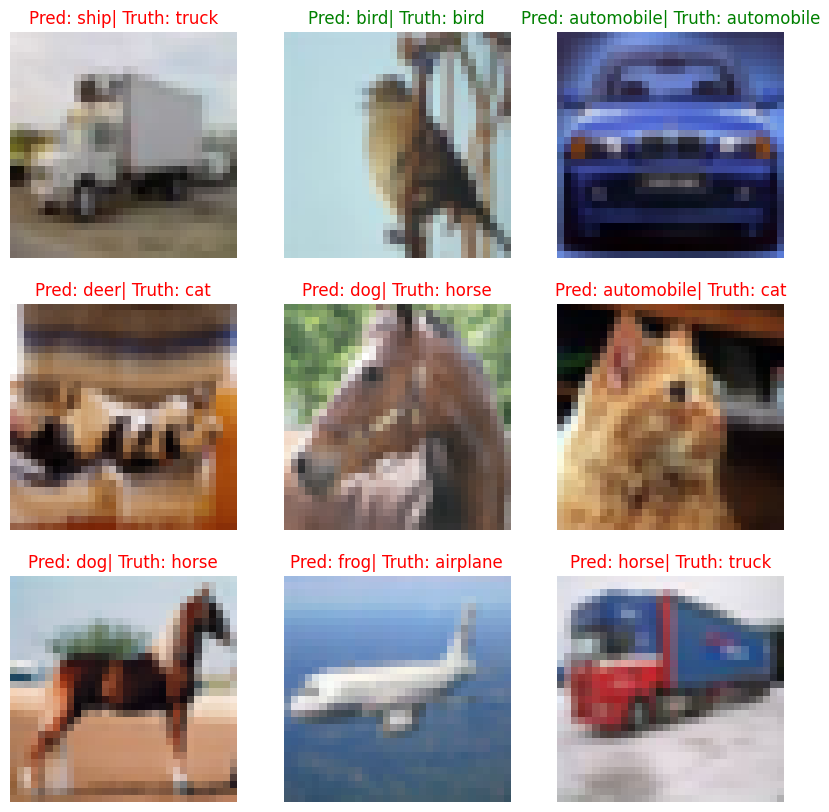

In [ ]:
# Lets visualize all that
fig = plt.figure(figsize=(10, 10))
rows, cols = 3, 3
for i, sample in enumerate(test_samples):
  pred_label = class_names[pred_labels[i]]
  truth_label = class_names[test_labels[i]]
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(sample.permute(1, 2, 0))
  if pred_label == truth_label:
    plt.title(f"Pred: {pred_label}| Truth: {truth_label}", c="g")
  else:
    plt.title(f"Pred: {pred_label}| Truth: {truth_label}", c="r")
  plt.axis(False)
